# Unsupervised Methods for Machine Learning

We've covered machine learning methods that are supervised, meaning we have labels in our data and we're training a model to be able to assign those labels.  Now we look at unsupervised methods that can extract meaning from data regardless of the precense of labels.  These methods can be helpful in situations where the data is not labeled but can also provide insight into patterns in labeled data as well.  The first method we'll covered is Principal Components Analysis, a very widespread technique in data science.

Much of the code is borrowed from this notebook: https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb

## Curse of Dimensionality

A lot of techniques for machine learning don't perform as well on data that has a high number of dimensions, or features/columns.  You start to see this once the number of features reaches the hundreds.  The various problems caused by high dimensional data are collectively referred to as *the curse of dimensionality*, and Principal Component Analysis is one of the methods for solving this problem.

PCA is a dimensionality reduction algorithm.  This means that we can apply PCA to our data to end up with less features than we started with.  The PCA algorithm takes the columns in our data set and figures out a way to recombine them in a way that reduces the overall number of columns while retaining as much of the information in the data as possible.

### Why would we want to do this?

As mentioned, a lot of algorithms perform poorly on high dimensional data, so running PCA on the data before feeding it to another algorithm is one way to increase performance, usually in the form of making the other algorithm run faster.  

But there are other reasons to use PCA as well.  A big one is that we can't visualize data in more than three dimensions, and usually visualize data in only two dimensions.  If you want to visualize a higher dimensional data set, say a data set with 10 dimensions (or columns), you can apply PCA to reduce the number of dimensions to 2, and then visualize those 2 dimensions.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

rng = np.random.RandomState(1)
data = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(data[:, 0], data[:, 1])
plt.axis('equal')

Here we have some data, a point cloud in two dimensions.  Is the variance of the data higher in the X axis direction or in the Y axis direction?  Is there a direction other than straight X and straight Y that has a higher variance?  If you were going to redraw the axes anywhere, where would you draw them to maximize the amount of variance on the X axis?

What PCA does is to 'redraw' these axes, the 'components' that PCA returns to us are the vectors along which the variance of our data is maximized.

We imported the PCA algorithm from sklearn, and we can use it like we use all the algorithms from sklearn.  First we initialize the object and then we call the fit method.  

In [72]:
pca = PCA(n_components=2) # we have two columns in our data, so we set the number of components to 2
# however we won't always set the number of components equal to the number of columns, more on this later
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The first thing we can get from our data is the actual components, the new axes for our data.

In [73]:
pca.components_

array([[-0.94446029, -0.32862557],
       [-0.32862557,  0.94446029]])

The other important thing we can get is the explained variance.

In [74]:
pca.explained_variance_

array([0.7625315, 0.0184779])

This is the amount of the variance in our data explained by the components we just extracted.  The first number is the explained variance with just the first component.  The second number is the increase in explained variance we get by including the second component. 

In [75]:
pca.explained_variance_ratio_

array([0.97634101, 0.02365899])

This is a little more helpful in my opinion, this is the proportion of the variance explained by each component.  So the first component of our data contains 98% of the information present in the data.

(-2.7391278364515688,
 2.5801310701596343,
 -0.9477947579593763,
 1.0195904306706842)

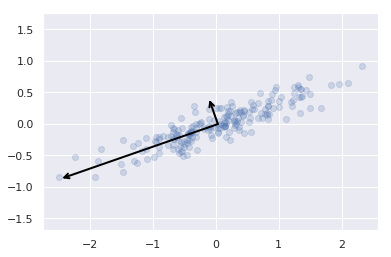

In [24]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    color='black',
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(data[:, 0], data[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal')

Now that we've fit the PCA to our data, we can use the transform method to map our data onto the components we extracted.

Text(0.5, 1.0, 'principal components')

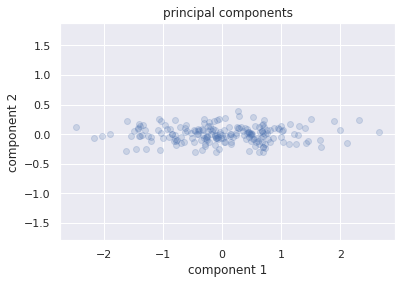

In [31]:
data_pca = pca.transform(data)
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.2)
plt.axis('equal')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('principal components')

Notice we still have the same number of dimensions that we started with.  To actually reduce the dimensions, we  extract the number of dimensions we want and set the components of the remaining dimensions to zero.  In practice, we just set the n_components argument to the number of dimensions we want.  We can reduce our two dimensional data set to one dimension.

In [34]:
pca = PCA(n_components=1)
pca.fit(data)
data_pca = pca.transform(data)
print(data.shape)
print(data_pca.shape)

(200, 2)
(200, 1)


We do an inverse transform here to be able to plot the two point clouds together, but notice that information is lost, we can't truly invert the pca transformation.

(-2.77152878069022, 2.661757596590677, -0.9964674432667129, 1.0219081775900811)

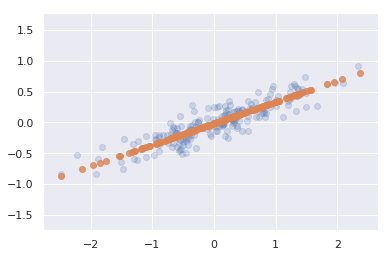

In [36]:
data_inv = pca.inverse_transform(data_pca)
plt.scatter(data[:, 0], data[:, 1], alpha=0.2)
plt.scatter(data_inv[:, 0], data_inv[:, 1], alpha=0.8)
plt.axis('equal')

## PCA in practice

Let's look at an example of the PCA algorithm in practice.  We're going to use a classic data set in ML, the Wisconsin Breast Cancer data set, which is a collection of characteristics of breast cancer cells along with a label of whether the cancer was benign or malignant. 

In [58]:
df = pd.read_csv('wisconsin_breast_cancer.csv')
# The original data set only had these 10 features, so we'll limit ourselves to these
df = df[['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
df.diagnosis = df.diagnosis.map({'M':1, 'B':0})

I want to visualize this data set, but it has 10 dimensions.  We will use PCA to reduce the dimensions to 2 and then visualize it.
 **But first, very important, we must scale the data using standard scaler.**

In [59]:
scaler = StandardScaler()
features = df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
features = scaler.fit_transform(features)

pca = PCA(n_components = 2)
features = pca.fit_transform(features)

df_pca = pd.concat([df[['id', 'diagnosis']], pd.DataFrame(features, columns=['component_1', 'component_2'])], axis=1)
df_pca.head()

,id,diagnosis,component_1,component_2
0,842302,1,5.224155,3.204428
1,842517,1,1.728094,-2.540839
2,84300903,1,3.969757,-0.550075
3,84348301,1,3.596713,6.905070
4,84358402,1,3.151092,-1.358072


<Figure size 432x288 with 0 Axes>

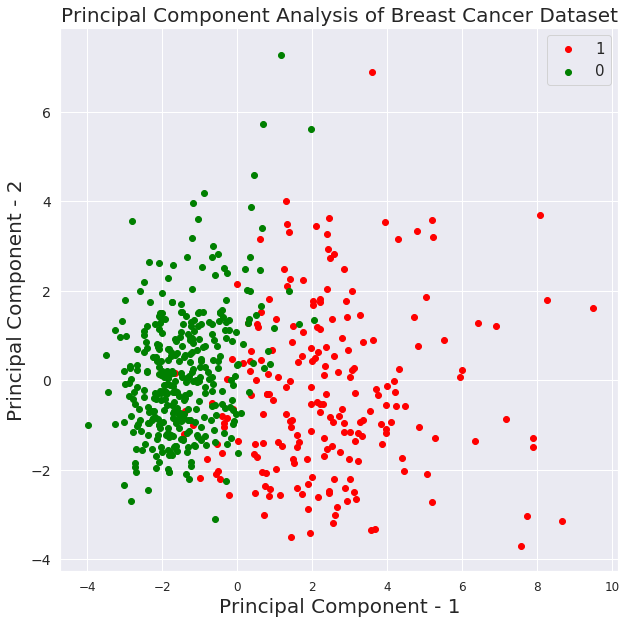

In [66]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Breast Cancer Dataset",fontsize=20)
plt.scatter(df_pca[df_pca.diagnosis == 1].component_1, df_pca[df_pca.diagnosis == 1].component_2,
           color = 'red')
plt.scatter(df_pca[df_pca.diagnosis == 0].component_1, df_pca[df_pca.diagnosis == 0].component_2,
           color = 'green')
plt.legend(targets,prop={'size': 15})

We can see that with just two components we can still separate the two different classes in the data set.

## Picking the Number of Components

In the above example, we reduced our data to two components because we were planning to make a 2-dimensional visualization.  If we're using PCA for another purpose, we could reduce our data to 3, 4, or other dimensions as well.  How do we pick a good number of components to extract from our data? 

The basic answer is to look at the variance explained by the components and stop adding components once we reach a point of diminishing returns. 

In [82]:
scaler = StandardScaler()
features = df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
features = scaler.fit_transform(features)

pca = PCA(n_components = 10)
features = pca.fit_transform(features)
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.cumsum()

[5.47858799e-01 2.51871359e-01 8.80615179e-02 4.99009436e-02
 3.72539190e-02 1.24141749e-02 8.00853104e-03 3.48897928e-03
 1.11354606e-03 2.82305888e-05]


array([0.5478588 , 0.79973016, 0.88779168, 0.93769262, 0.97494654,
       0.98736071, 0.99536924, 0.99885822, 0.99997177, 1.        ])

In [83]:
scaler = StandardScaler()
features = df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]
features = scaler.fit_transform(features)

pca = PCA(n_components = 5)
features = pca.fit_transform(features)
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.cumsum()

[0.5478588  0.25187136 0.08806152 0.04990094 0.03725392]


array([0.5478588 , 0.79973016, 0.88779168, 0.93769262, 0.97494654])

So with this data, 3, 4, or 5 would all be reasonable choices for the number of components to keep.

## Clustering